In [1]:
!pip install mlflow boto3 awscli

In [2]:
import mlflow
mlflow.set_tracking_uri("http://ec2-98-89-32-32.compute-1.amazonaws.com:5000/")

In [3]:
mlflow.set_experiment("Exp 3 - TfIdf Trigram max_features")

2025/12/13 23:08:01 INFO mlflow.tracking.fluent: Experiment with name 'Exp 3 - TfIdf Trigram max_features' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-s3-bucket-25/742346887914634061', creation_time=1765647481168, experiment_id='742346887914634061', last_update_time=1765647481168, lifecycle_stage='active', name='Exp 3 - TfIdf Trigram max_features', tags={}>

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [5]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

2025/12/13 23:15:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run TFIDF_Trigrams_max_features_1000 at: http://ec2-98-89-32-32.compute-1.amazonaws.com:5000/#/experiments/742346887914634061/runs/4565f90dc56b42a283fa8c813a7b9f0b.
2025/12/13 23:15:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ec2-98-89-32-32.compute-1.amazonaws.com:5000/#/experiments/742346887914634061.


S3UploadFailedError: Failed to upload confusion_matrix.png to mlflow-s3-bucket-25/742346887914634061/4565f90dc56b42a283fa8c813a7b9f0b/artifacts/confusion_matrix.png: An error occurred (SignatureDoesNotMatch) when calling the PutObject operation: The request signature we calculated does not match the signature you provided. Check your key and signing method.

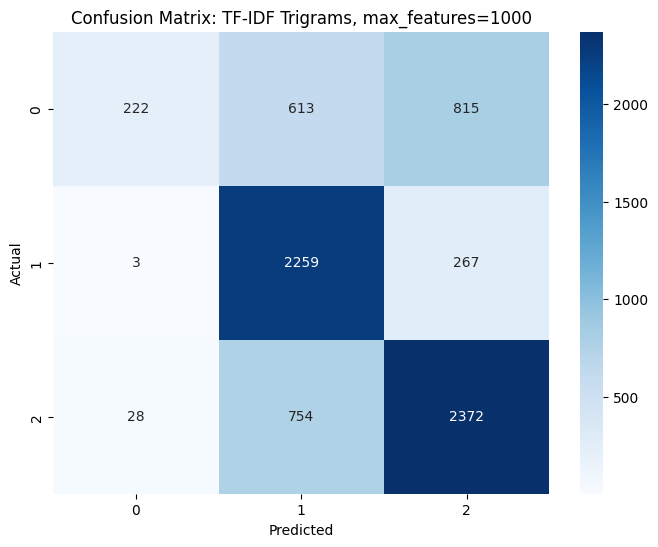

In [ ]:
# Run experiment
def run_experiment_tfidf_max_features(max_features):
    ngram_range = (1, 3)  # Trigram setting

    # Vectorization using TF-IDF with varying max_features
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range, max_features=max_features)

    X_train, X_test, y_train, y_test = train_test_split(
        df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName",
                       f"TFIDF_Trigrams_max_features_{max_features}")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag(
            "description", f"RandomForest with TF-IDF Trigrams, max_features={max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(
            y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(
            f"Confusion Matrix: TF-IDF Trigrams, max_features={max_features}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(
            model, f"random_forest_model_tfidf_trigrams_{max_features}")

  
# Test various max_features values
max_features_values = [1000, 2000, 3000,
                       4000, 5000, 6000, 7000, 8000, 9000, 10000]

for max_features in max_features_values:
    run_experiment_tfidf_max_features(max_features)